In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from lstm_class import Lstm
from sklearn.metrics import mean_squared_error

# Load Dataset

In [2]:
std_stocks = pd.read_csv("../data/stock_standard_1.csv").iloc[:, 3:] # Drop the First Three Columns
std_stocks = std_stocks.sort_values(by=['tic', 'datadate'])
std_stocks.drop(columns=['conm', 'gsector'], inplace=True)
std_stocks.reset_index(inplace=True)
stock_names = std_stocks['tic'].unique()
std_stocks.head()

,index,datadate,tic,cshtrm,prccm,prchm,prclm,trt1m,CAPEI,evm,...,high_low_ratio,RSI_14,MA_3,price_to_MA_3,return_momentum_6m,MA_6,return_momentum_9m,MA_9,return_momentum_12m,MA_12
0,22,2011-03-31,AMZN,0.057669,0.050441,0.047726,0.048270,0.449252,0.657229,0.104348,...,0.020950,0.599129,0.050675,0.673276,0.278596,0.050655,0.346955,0.046881,0.203680,0.044979
1,64,2011-04-30,AMZN,0.055855,0.054863,0.052030,0.052741,0.479247,0.657454,0.104348,...,0.020388,0.647066,0.053232,0.698572,0.291211,0.052154,0.350194,0.049443,0.222852,0.046454
2,106,2011-05-31,AMZN,0.051408,0.055111,0.054307,0.057432,0.427200,0.657571,0.104227,...,0.010842,0.669937,0.055518,0.671418,0.270170,0.053198,0.327768,0.051806,0.249207,0.048244
3,148,2011-06-30,AMZN,0.046094,0.057310,0.054270,0.054622,0.449368,0.657700,0.104227,...,0.022005,0.668990,0.057899,0.669438,0.275018,0.054399,0.255807,0.053366,0.306600,0.050637
4,190,2011-07-31,AMZN,0.044648,0.062395,0.059825,0.061283,0.479955,0.657969,0.104227,...,0.017924,0.721217,0.060509,0.699107,0.333047,0.056992,0.267572,0.055250,0.309609,0.053266


In [3]:
# Dictionary to hold dataframe for each stock
# Shift the Target Return up because we want to use X features at t to predict returns at t+1
df_per_stock = {}
for stock in stock_names:
    df = std_stocks[std_stocks['tic'] == stock]
    df['trt1m'] = df['trt1m'].shift(-1) # Shift Target Return up
    df = df.dropna() # Drop any rows with NA values
    df_per_stock[stock] = df 

/var/folders/z8/18vf272n36z6tx1xm5tv3qvw0000gn/T/ipykernel_55378/1219244669.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trt1m'] = df['trt1m'].shift(-1) # Shift Target Return up


# Preprocessing Features for LSTM Model

In [4]:
# Lets first try to get the model to run for 1 stock
amzn = df_per_stock['AMZN'].iloc[:, 1:]
y = amzn['trt1m'].values
amzn.drop(columns=['trt1m'], inplace=True)
X = amzn.iloc[:, 2:].values
print(f"The Shape of X Features is: {X.shape}")
print(f"The Shape of y Features is: {y.shape}")

The Shape of X Features is: (153, 63)
The Shape of y Features is: (153,)


In [5]:
sequence_length = 12 # Feed past 12 month returns into sequence for LSTM
# Converting Features into 3D space for LSTM to add a time component
X_features, y_target = [], []
for i in range(X.shape[0] - sequence_length):
    X_features.append(X[i:i+sequence_length])
    y_target.append(y[i + sequence_length])
X_features = np.array(X_features)
y_target = np.array(y_target)

In [6]:
print(f"The Shape of X Features is: {X_features.shape}")
print(f"The Shape of y Features is: {y_target.shape}")

The Shape of X Features is: (141, 12, 63)
The Shape of y Features is: (141,)


In [7]:
train_size = int(len(amzn) * 0.8)
print(f"The size of my training set will be : {train_size} and the test set will be : {int(len(amzn)) - train_size}")
X_train, y_train = X_features[:train_size], y_target[:train_size]
y_train.reshape(-1, 1)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
X_test, y_test = X_features[train_size:], y_target[train_size:]
y_target.reshape(-1, 1)
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

The size of my training set will be : 122 and the test set will be : 31
Shape of X_train: (122, 12, 63)
Shape of y_train: (122,)
Shape of X_test: (19, 12, 63)
Shape of y_test: (19,)


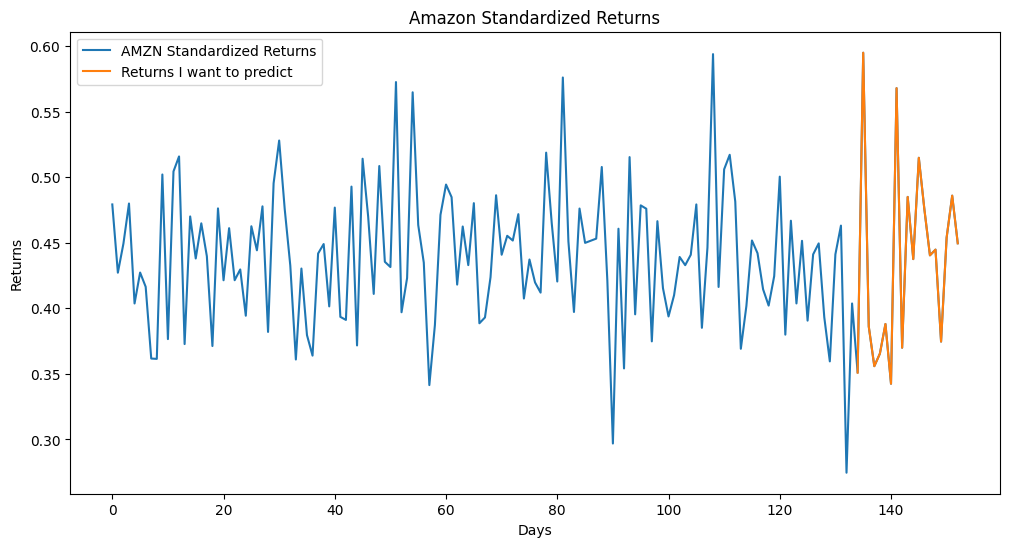

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(df_per_stock['AMZN']['trt1m'], label='AMZN Standardized Returns')
plt.plot(df_per_stock['AMZN']['trt1m'][-19:], label='Returns I want to predict')
plt.title(f'Amazon Standardized Returns')
plt.xlabel('Days')
plt.ylabel('Returns')
plt.legend()
plt.show()

# Train LSTM Model

In [9]:
# Train LSTM Model
lstm_model = Lstm(input_shape=(sequence_length, X_train.shape[2]), epochs=10, batch_size=32, dense_units=[100, 50], optimizer='adam')

In [10]:
lstm_model.fit(X_train=X_train, y_train=y_train)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1106 - mse: 0.1106
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0071 - mse: 0.0071 
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0046 - mse: 0.0046
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0037 - mse: 0.0037
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0038 - mse: 0.0038
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0035 - mse: 0.0035
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mse: 0.0033
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mse: 0.0029
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0026 - mse: 0.0026
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mse: 0.0029


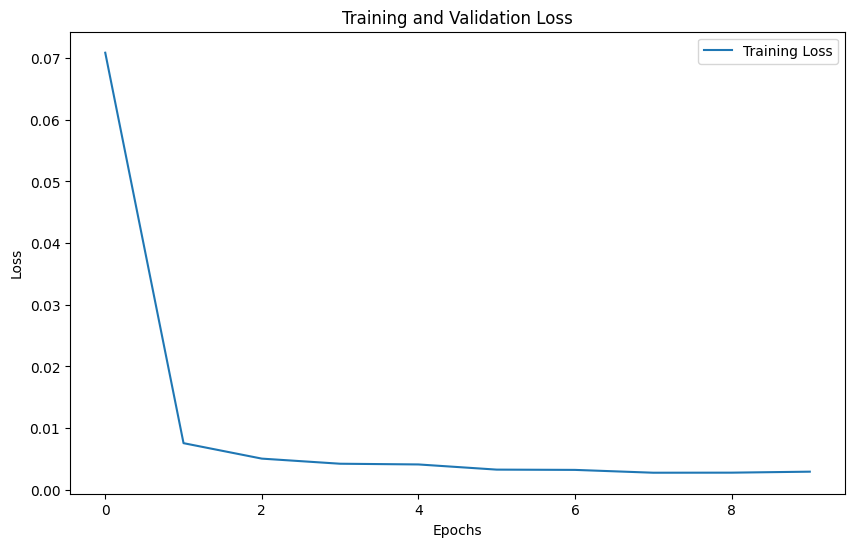

In [11]:
lstm_model.plot_performance()

# Hyperparameter Tuning

In [12]:
param_grid = {
    'lstm_units': [50, 100, 150],
    'dense_units1': [50, 100, 150],
    'dense_units2': [25, 50, 75],
    'optimizer': ['adam', 'rmsprop']
}

In [13]:
# Run hyperparameter tuning
best_config = lstm_model.hyperparameter_tuning(X_train, y_train, param_grid, n_splits=5, csv_path="hyperparameter_tuning_results.csv")


Current Parameters: {'lstm_units': 50, 'dense_units1': 50, 'dense_units2': 25, 'optimizer': 'adam'}
Train shapes: X_train: (22, 12, 63), y_train: (22,)
Val shapes: X_val: (20, 12, 63), y_val: (20,)
Train shapes: X_train: (42, 12, 63), y_train: (42,)
Val shapes: X_val: (20, 12, 63), y_val: (20,)
Train shapes: X_train: (62, 12, 63), y_train: (62,)
Val shapes: X_val: (20, 12, 63), y_val: (20,)
Train shapes: X_train: (82, 12, 63), y_train: (82,)
Val shapes: X_val: (20, 12, 63), y_val: (20,)
Train shapes: X_train: (102, 12, 63), y_train: (102,)
Val shapes: X_val: (20, 12, 63), y_val: (20,)
Params: {'lstm_units': 50, 'dense_units1': 50, 'dense_units2': 25, 'optimizer': 'adam'}, Average Validation MSE: 0.0037
Results saved to hyperparameter_tuning_results.csv
Current Parameters: {'lstm_units': 50, 'dense_units1': 50, 'dense_units2': 25, 'optimizer': 'rmsprop'}
Train shapes: X_train: (22, 12, 63), y_train: (22,)
Val shapes: X_val: (20, 12, 63), y_val: (20,)
Train shapes: X_train: (42, 12, 63),

In [14]:
best_config

{'lstm_units': 150,
 'dense_units1': 100,
 'dense_units2': 50,
 'optimizer': 'adam'}

In [15]:
amzn_model = Lstm(input_shape=(sequence_length, X_train.shape[2]),
                  epochs=10,
                  batch_size=32,
                  lstm_units=best_config['lstm_units'],
                  dense_units=[best_config['dense_units1'], best_config['dense_units2']],
                  optimizer=best_config['optimizer'])

In [16]:
amzn_model.fit(X_train=X_train, y_train=y_train)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0892 - mse: 0.0892
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072 - mse: 0.0072 
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0057 - mse: 0.0057
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0040 - mse: 0.0040
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0038 - mse: 0.0038
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - mse: 0.0028
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mse: 0.0031
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026 - mse: 0.0026
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027 - mse: 0.0027
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0028 - mse: 0.0028


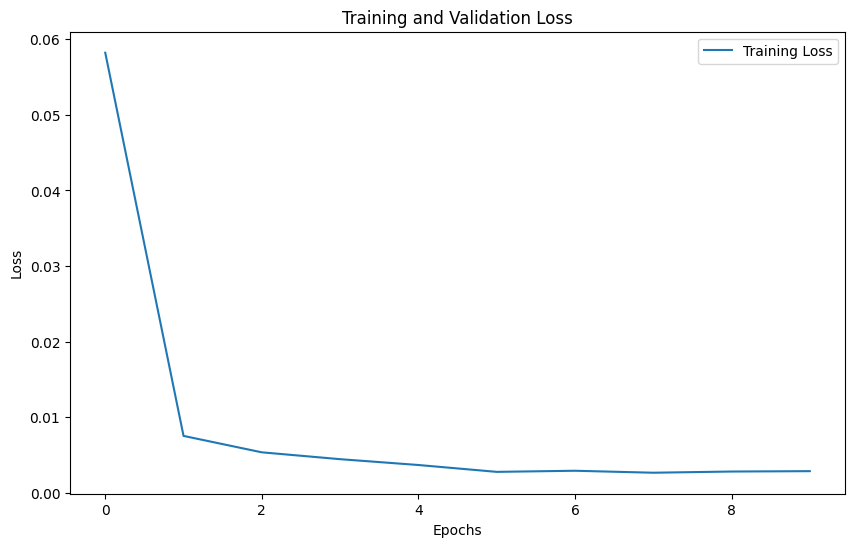

In [18]:
amzn_model.plot_performance()

In [19]:
predicted_return= amzn_model.model.predict(X_test)
mse = mean_squared_error(y_test, predicted_return.flatten())
print(f"For Stock AMZN the MSE is {mse}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
For Stock AMZN the MSE is 0.005256337546700923


In [22]:
y_test

array([0.3509449 , 0.59496581, 0.38615205, 0.35588577, 0.36545041,
       0.38805602, 0.34247473, 0.56794576, 0.36995943, 0.48498413,
       0.43755119, 0.51482484, 0.47550208, 0.44042354, 0.44478818,
       0.37461976, 0.45397518, 0.48594873, 0.44961306])

In [24]:
predicted_return.flatten()

array([0.40688792, 0.4067642 , 0.40767008, 0.40769655, 0.4082533 ,
       0.41041702, 0.41310218, 0.41560888, 0.41562617, 0.4159885 ,
       0.41747552, 0.41906837, 0.4204554 , 0.4225698 , 0.4248638 ,
       0.42626098, 0.42640668, 0.42652076, 0.42671925], dtype=float32)

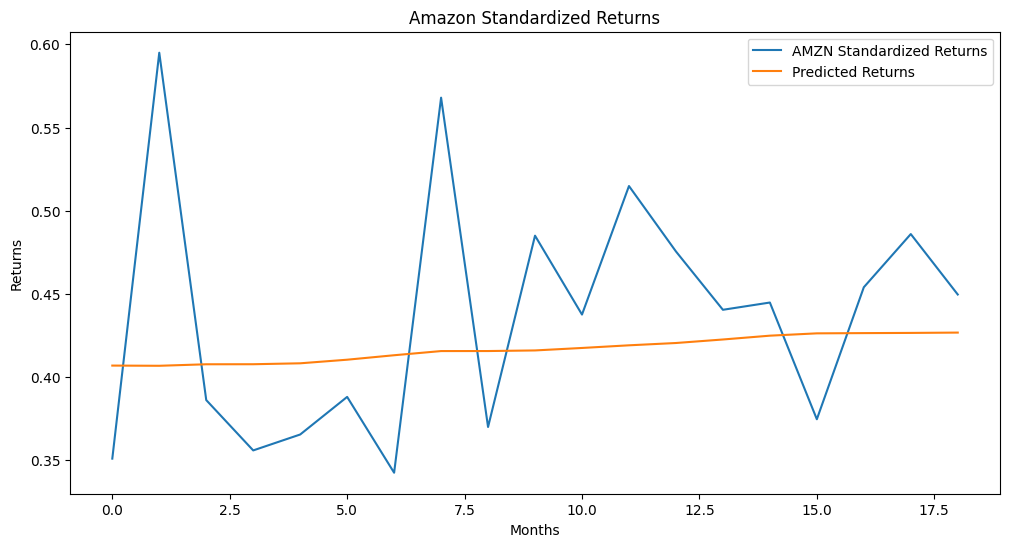

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='AMZN Standardized Returns')
plt.plot(predicted_return, label='Predicted Returns')
plt.title(f'Amazon Standardized Returns')
plt.xlabel('Months')
plt.ylabel('Returns')
plt.legend()
plt.show()

# Train, and Predict for each Asset

In [ ]:
# Train Models for each Stock
models = {}
sequence_length = 7 # 70 Day Return Data
for i in range(num_stocks):
    stock_data = train[:, i].reshape(-1, 1) # Convert 1D array to 2D Vector
    lstm_model = Lstm(input_shape=(sequence_length, 1))
    X_train, y_train = create_sequences(stock_data, sequence_length)
    print(f"Shape of X_train: {X_train.shape}")
    print(f"Shape of y_train: {y_train.shape}")
    lstm_model.fit(X_train, y_train)
    models[i] = lstm_model

In [ ]:
# Store MSE
mse = {}
# Function to predict returns
def predict_returns(models, data, sequence_length=7):
    predicted_returns = []
    for i in range(num_stocks):
        model = models[i]
        stock_data = data[:, i].reshape(-1, 1)
        X_test, y_test = create_sequences(stock_data, sequence_length)
        #print(f"For Stock {i + 1} Shape of X_test: {X_test.shape}")
        #print(f"For Stock {i + 1} Shape of y_test: {y_test.shape}")
        predicted_return = model.model.predict(X_test)
        #print(f"For Stock {i + 1} Shape of predicted_return: {predicted_return.shape}")
        mse_ = mean_squared_error(y_test, predicted_return.flatten())
        print(f"For Stock {i + 1} the MSE is {mse_}")
        mse[i] = mse_
        predicted_returns.append(predicted_return.flatten())
    return np.array(predicted_returns).T

# Predict returns using the LSTM models
predicted_returns = predict_returns(models, test, sequence_length)
# Rescale the predicted returns to original scale
#predicted_returns = scaler.inverse_transform(predicted_returns)
print(mse)

In [ ]:
predicted_returns[:, 0]

In [ ]:
test[7:, :][:, 0]

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot((1 + test[7:, :][:, 0]).cumprod(), label='Actual Returns')
plt.plot((1 + predicted_returns[:, 0]).cumprod(), label='Predicted Returns')
plt.title(f'Predicted vs Actual Returns for Stock 1')
plt.xlabel('Days')
plt.ylabel('Returns')
plt.legend()
plt.show()

In [ ]:
# Plot predicted vs actual returns for a single stock
stock_index = 1  # Change this index to plot for a different stock
actual_returns = scaler.inverse_transform(test[sequence_length:])[:, stock_index]

plt.figure(figsize=(12, 6))
plt.plot(actual_returns, label='Actual Returns')
plt.plot(predicted_returns[:, stock_index], label='Predicted Returns')
plt.title(f'Predicted vs Actual Returns for Stock {stock_index + 1}')
plt.xlabel('Days')
plt.ylabel('Returns')
plt.legend()
plt.show()

In [ ]:
100 * (1 + actual_returns).cumprod()

In [ ]:
100 * (1 + predicted_returns[:, stock_index]).cumprod()

In [ ]:
# Plot the actual vs predicted prices for the first asset
plt.figure(figsize=(12, 6))
plt.plot(actual_returns, label='Actual Returns')
plt.plot(predicted_returns[:, stock_index], label='Predicted Returns')
plt.title('Actual vs Predicted Returns of the First Asset')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Plot the actual vs predicted prices for the first asset
plt.figure(figsize=(12, 6))
plt.plot(100 * (1 + actual_returns).cumprod(), label='Actual Prices')
plt.plot(100 * (1 + predicted_returns[:, stock_index]).cumprod(), label='Predicted Prices')
plt.title('Actual vs Predicted Prices of the First Asset')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()